# Pythagorean Won Loss Formula Notebook

Initial setup

In [1]:
try:
    import google.colab
    import requests
    exec(requests.get("https://raw.githubusercontent.com/Something-Else-Studio/arcticdb-notebooks/main/styling.py").text)
    dataFile = 'https://raw.githubusercontent.com/Something-Else-Studio/arcticdb-notebooks/main/pythagorean-won-loss-formula/sports.csv'
except ImportError:
    %load_ext autoreload
    %autoreload 2
    import sys, os
    sys.path.append(os.path.dirname(os.getcwd()))
    from styling import *
    dataFile = "sports.csv"

In [2]:
%pip -q install arcticdb pandas numpy statsmodels seaborn matplotlib plotly scikit-learn
import arcticdb as adb
adb.__version__

Note: you may need to restart the kernel to use updated packages.


'6.1.0'

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Setup custom chart styling instead of sns.set_theme()
chart_colors = setup_chart_styling()
colors = setup_plotly_theme()

In [4]:
df = pd.read_csv(dataFile)

In [5]:
df = df.drop(columns="Unnamed: 0")
df = df.rename(columns={'FREQ_RUNS_S': 'PS',
                        'FREQ_RUNS_A': 'PA' })

df = df.sort_values(['LEAGUE','YEAR_ID','TEAM_ID'])
styled = style_table(df.head())
export_table(styled, "basic_data")
styled

Exported: basic_data.html
Exported: basic_data.csv


YEAR_ID,TEAM_ID,OPP_TEAM_ID,PS,PA,date,home,wi,LEAGUE
1897,Carlton,Fitzroy,16,49,1897-05-08,0,0.000000,AFL
1897,Carlton,South Melbourne,36,40,1897-05-15,0,0.000000,AFL
1897,Carlton,Essendon,41,78,1897-05-24,0,0.000000,AFL
1897,Carlton,Geelong,22,44,1897-05-29,0,0.000000,AFL
1897,Carlton,Melbourne,26,107,1897-06-05,0,0.000000,AFL


In [6]:
# Demonstrate head/tail table display showing first 10 and last 10 rows
from styling import style_head_tail_table

# Create a head/tail display of the full dataset
styled_head_tail = style_head_tail_table(df, head_rows=10, tail_rows=10)
export_table(styled_head_tail, "head_tail_data", "Sports Data - First 10 and Last 10 Rows")
styled_head_tail

Exported: head_tail_data.html
Exported: head_tail_data.csv


YEAR_ID,TEAM_ID,OPP_TEAM_ID,PS,PA,date,home,wi,LEAGUE
1897,Carlton,Fitzroy,16,49,1897-05-08,0,0.000000,AFL
1897,Carlton,South Melbourne,36,40,1897-05-15,0,0.000000,AFL
1897,Carlton,Essendon,41,78,1897-05-24,0,0.000000,AFL
1897,Carlton,Geelong,22,44,1897-05-29,0,0.000000,AFL
1897,Carlton,Melbourne,26,107,1897-06-05,0,0.000000,AFL
1897,Carlton,St Kilda,35,24,1897-06-19,0,1.000000,AFL
1897,Carlton,Collingwood,35,41,1897-06-22,1,0.000000,AFL
1897,Carlton,Fitzroy,9,47,1897-06-26,1,0.000000,AFL
1897,Carlton,South Melbourne,28,74,1897-07-03,1,0.000000,AFL
1897,Carlton,Essendon,13,42,1897-07-10,1,0.000000,AFL


In [7]:
arctic = adb.Arctic('lmdb://sports')
lib = arctic.get_library('leagues', create_if_missing=True)
for league in df['LEAGUE'].unique():
    lib.write(league, df[df['LEAGUE']==league])
lib.list_symbols()

['IPL', 'NFL', 'NHL', 'SUP', 'MLB', 'NBA', 'LAX', 'EPL', 'AFL']

In [8]:
style_head_tail_table(lib.read('LAX').data, head_rows=5, tail_rows=5)

YEAR_ID,TEAM_ID,OPP_TEAM_ID,PS,PA,date,home,wi,LEAGUE
2010,Air Force,St. John's (NY),7,10,2010-02-28,1,0.000000,LAX
2010,Air Force,Lehigh,13,14,2010-03-06,1,0.000000,LAX
2010,Air Force,Penn,7,8,2010-03-07,1,0.000000,LAX
2010,Air Force,Army West Point,8,7,2010-03-13,1,1.000000,LAX
2010,Air Force,Loyola Maryland,3,18,2010-03-20,0,0.000000,LAX
...,...,...,...,...,...,...,...,...
2019,Yale,Penn,11,12,2019-05-05,1,0.000000,LAX
2019,Yale,Georgetown,19,16,2019-05-11,1,1.000000,LAX
2019,Yale,Penn,19,18,2019-05-19,1,1.000000,LAX
2019,Yale,Penn St.,21,17,2019-05-25,1,1.000000,LAX


In [9]:
def ols_coef (df, xcol, ycol):
    """simple OLS function used for lambda calcs -- assumes univariate regression"""
    model=sm.OLS(df[ycol],sm.add_constant(df[xcol])).fit()    

    outdf = pd.DataFrame({'adj.'    : model.params.iloc[0],
                          'adj. se' : model.bse.iloc[0],
                          'λ'    : model.params.iloc[1],
                          'λ se' : model.bse.iloc[1],
                          'nobs' : model.nobs,
                          'adj. $R^2$': model.rsquared_adj}, index=[0])    

    return outdf

Our study period is from 2010 to 2019

In [10]:
st_year_ = 2010
end_year_ = 2019

### Connect to ArcticDB and get list of leagues

In [11]:
arctic = adb.Arctic('lmdb://sports')
league_data = arctic.get_library('leagues')
leagues = league_data.list_symbols()
leagues

20250822 15:00:43.846377 94255 W arcticdb | LMDB path at /home/nick/source/customers/man-group/arcticdb-notebooks/pythagorean-won-loss-formula/sports/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[94255]


['IPL', 'NFL', 'NHL', 'SUP', 'MLB', 'NBA', 'LAX', 'EPL', 'AFL']

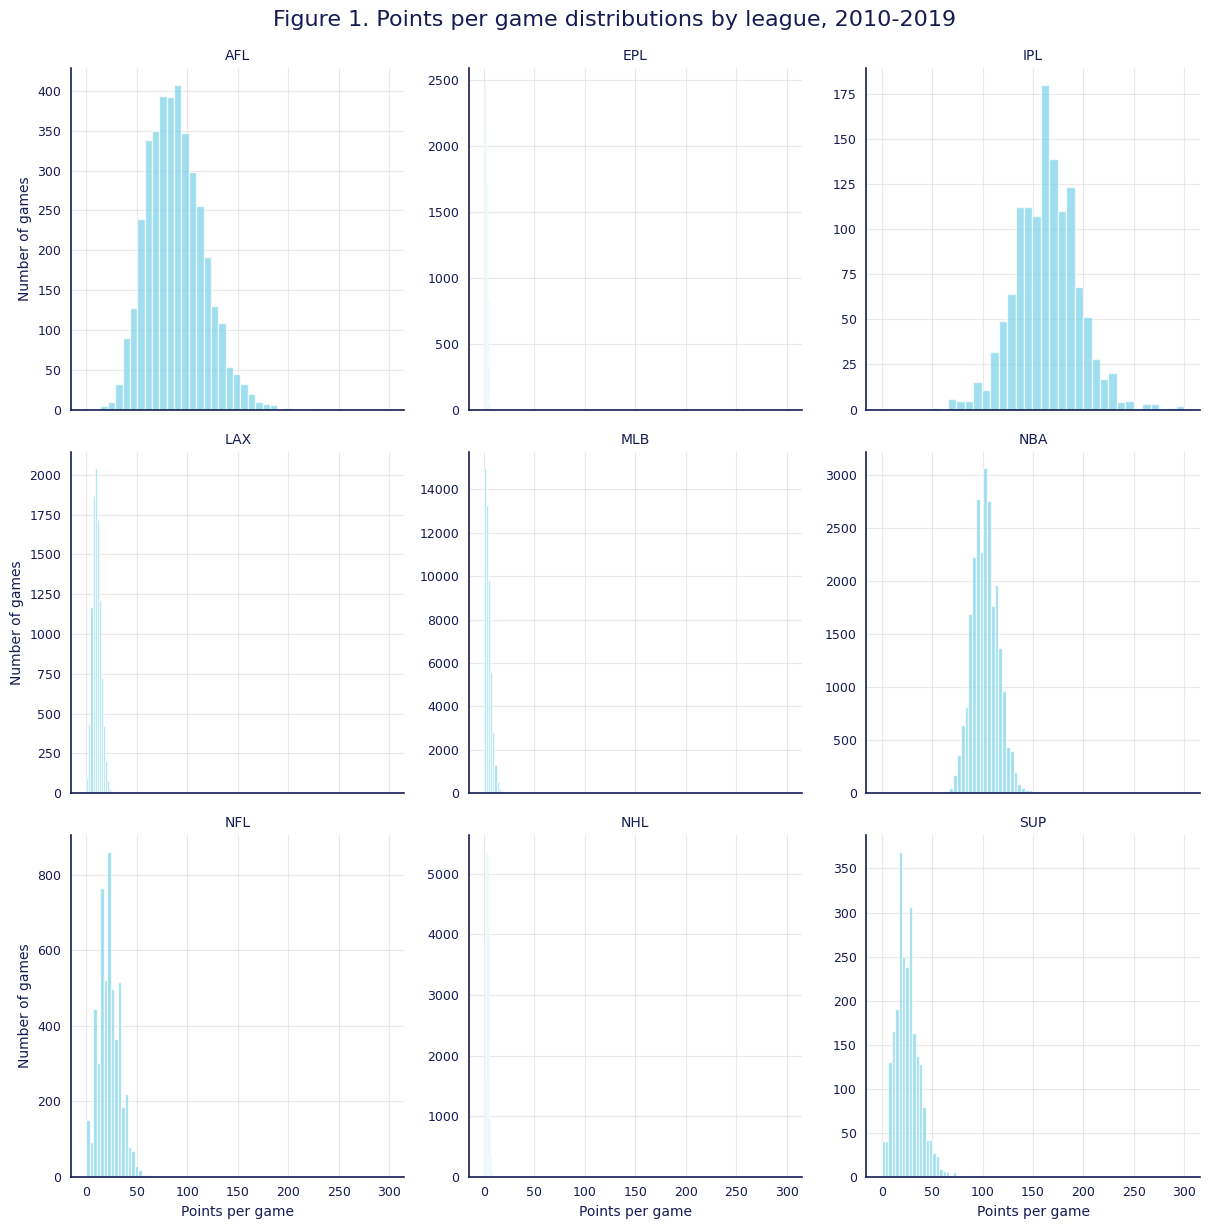

Exported: figure1_points_distributions.html
Exported: figure1_points_distributions.json


In [12]:
# Get points scored data for all games, 2010-2019 seasons  
lazy_dfs = league_data.read_batch(leagues, lazy=True)
lazy_dfs = lazy_dfs[(lazy_dfs['YEAR_ID']>=st_year_) & (lazy_dfs['YEAR_ID']<=end_year_)]
lazy_dfs = adb.concat(lazy_dfs)
points_data = lazy_dfs.collect().data[['LEAGUE', 'PS']]

# Define league order to match Figure 1 layout (3x3 grid, alphabetical)
league_order = ['AFL', 'EPL', 'IPL', 'LAX', 'MLB', 'NBA', 'NFL', 'NHL', 'SUP']

# Function to calculate optimal bins for each league
def get_optimal_bins(data, x_col, league):
    league_data = data[data['LEAGUE'] == league][x_col]
    data_range = league_data.max() - league_data.min()
    
    if data_range <= 15:  # Low-scoring sports (EPL, NHL)
        optimal_bins = min(15, int(data_range) + 1)
    elif data_range <= 50:  # Medium-scoring
        optimal_bins = min(25, int(data_range * 0.5))
    else:  # High-scoring sports
        optimal_bins = min(30, int(data_range * 0.3))
    
    return max(10, optimal_bins)  # Minimum 10 bins

# Create static seaborn histogram with faceting - Figure 1
grid = sns.FacetGrid(points_data, col='LEAGUE', col_wrap=3, col_order=league_order, 
                     height=4, aspect=1.0, sharey=False)

# Apply adaptive binning to each subplot
def plot_adaptive_hist(x, **kwargs):
    league = kwargs.get('label', 'Unknown')
    # Get current axes to determine which league we're plotting
    current_ax = plt.gca()
    title = current_ax.get_title()
    if '=' in title:
        league = title.split('=')[1].strip()
    
    optimal_bins = get_optimal_bins(points_data, 'PS', league)
    plt.hist(x, bins=optimal_bins, color=chart_colors['primary_color'], alpha=0.7)

grid.map(plot_adaptive_hist, 'PS')
grid.set_axis_labels('Points per game', 'Number of games')
grid.set_titles('{col_name}')
grid.fig.suptitle('Figure 1. Points per game distributions by league, 2010-2019', 
                  fontsize=16, y=1.02)

# Apply custom styling
for ax in grid.axes.flat:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color(chart_colors['secondary_color'])
        spine.set_linewidth(1.2)
    ax.tick_params(colors=chart_colors['text_color'], labelsize=9)
    ax.grid(True, color='#E0E0E0', linewidth=0.8, alpha=0.7)
    ax.set_axisbelow(True)

plt.show()

# Create and display interactive Plotly version with adaptive binning
fig = create_plotly_histplot(
    data=points_data,
    x_col='PS',
    col_col='LEAGUE',
    col_order=league_order,  # Same order as seaborn
    col_wrap=3,  # 3x3 grid layout
    title='Figure 1. Points per game distributions by league, 2010-2019',
    adaptive_bins=True  # Use adaptive binning to fix EPL/NHL gaps
)

# Update axis labels to match Figure 1
fig.update_xaxes(title_text="Points per game")
fig.update_yaxes(title_text="Number of games")

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "figure1_points_distributions", "Figure 1 - Points per game distributions")

In [13]:
# points scored for all games
lazy_dfs = league_data.read_batch(leagues, lazy=True)
lazy_dfs = lazy_dfs[(lazy_dfs['YEAR_ID']>=st_year_) & (lazy_dfs['YEAR_ID']<=end_year_)]
lazy_dfs = adb.concat(lazy_dfs)
points_scored = lazy_dfs.collect().data[['LEAGUE', 'PS']]
style_table(points_scored)

LEAGUE,PS
IPL,159
IPL,164
IPL,203
IPL,136
IPL,135
IPL,180
IPL,160
IPL,173
IPL,246
IPL,165


### Figure 1 calculate points-scored stats
- check positive skew comment in text
- note need help to plot via python like r panel plot

In [14]:
point_stats = points_scored.groupby(['LEAGUE']).agg(Mean=('PS', 'mean'),
                                             Std=('PS', 'std'),
                                             Skew=('PS', 'skew'),
                                             nobs=('PS', 'count'))
point_stats['IR']=point_stats['Mean']/point_stats['Std']
point_stats = point_stats.sort_values(['IR'])
style_table(point_stats.round(2), hide_index=False)

,Mean,Std,Skew,nobs,IR
LEAGUE,,,,,
EPL,1.380000,1.260000,1.030000,7600,1.090000
MLB,4.390000,3.100000,1.000000,48594,1.420000
NHL,2.810000,1.640000,0.420000,23744,1.710000
SUP,25.100000,11.970000,0.880000,2402,2.100000
NFL,22.640000,10.180000,0.290000,5120,2.230000
LAX,10.260000,3.980000,0.500000,10006,2.580000
AFL,88.300000,27.750000,0.480000,3892,3.180000
IPL,163.270000,31.420000,0.160000,1274,5.200000
NBA,102.240000,12.660000,0.180000,24118,8.080000


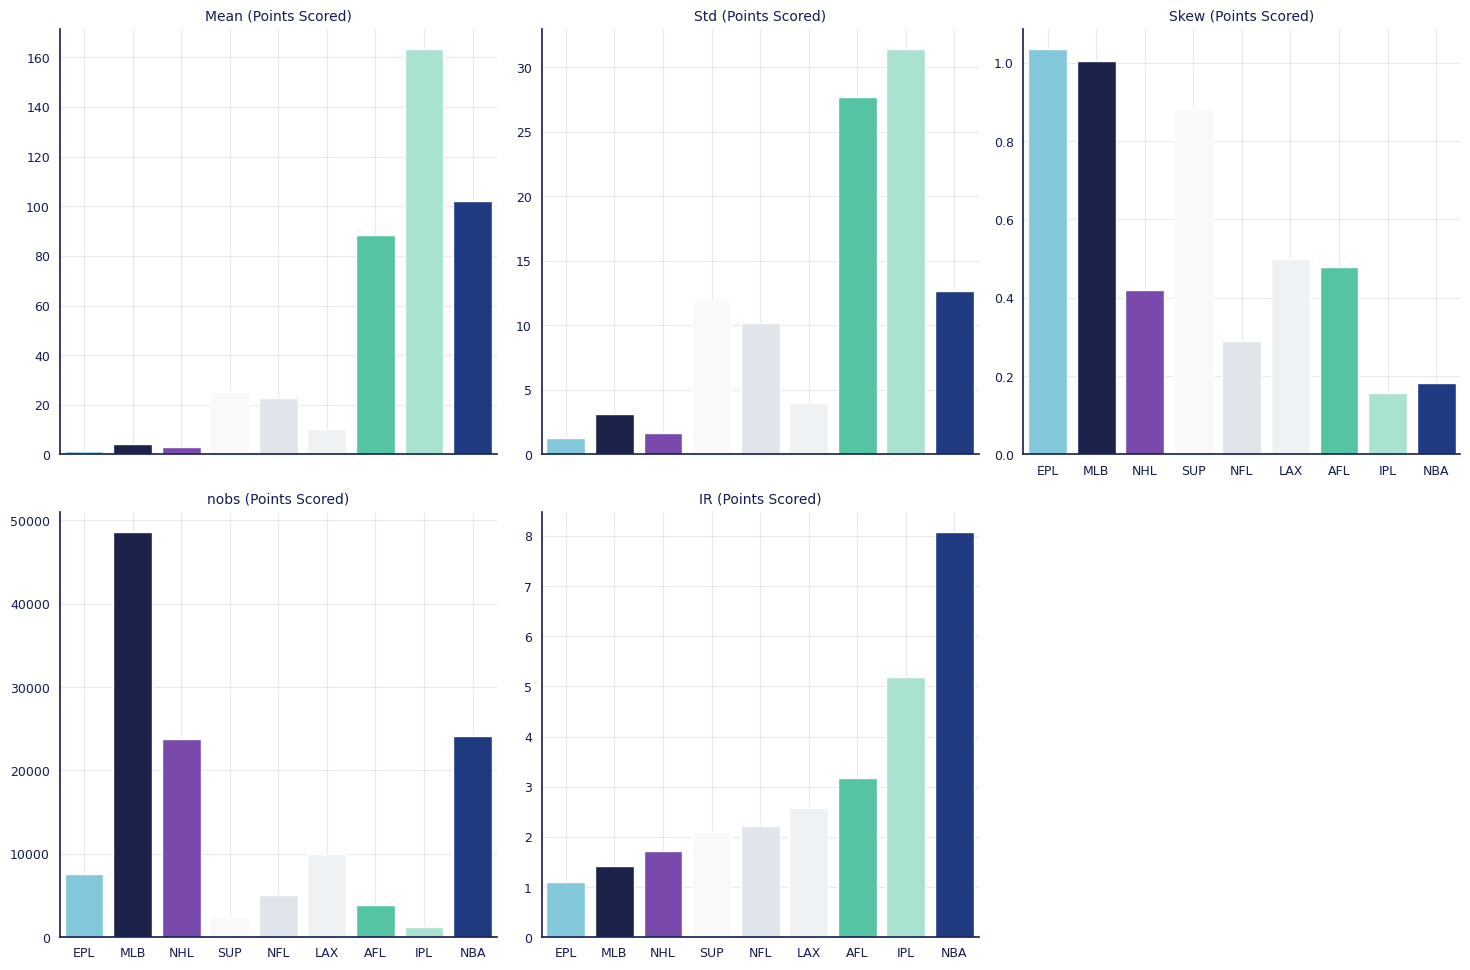

Exported: point_stats_catplot.html
Exported: point_stats_catplot.json


In [15]:
# Create static seaborn catplot
grid = sns.catplot(point_stats.reset_index().melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_wrap=3,
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name} (Points Scored)")

# Apply custom styling
style_catplot(grid, chart_colors)
plt.show()

# Create and display interactive Plotly version with same layout
fig = create_plotly_catplot(
    data=point_stats.reset_index().melt(['LEAGUE']),
    x_col="LEAGUE",
    y_col="value",
    hue_col="LEAGUE",
    col_col="variable",
    col_wrap=3,  # Same as seaborn version
    title="Figure 1. Points Scored Statistics by League",
    sharey=False
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "point_stats_catplot", "Points Scored Statistics")

### Save into ArcticDB

In [16]:
analysis = arctic.get_library('analysis', create_if_missing=True)
analysis.write('point_stats', point_stats)

VersionedItem(symbol='point_stats', library='analysis', data=n/a, version=15, metadata=None, host='LMDB(path=/home/nick/source/customers/man-group/arcticdb-notebooks/pythagorean-won-loss-formula/sports)', timestamp=1755871246965144453)

In [17]:
lazy_dfs = league_data.read_batch(leagues, lazy=True)
df = adb.concat(lazy_dfs).collect().data[['LEAGUE','YEAR_ID','TEAM_ID','PS','PA','wi']]
df_team = df.groupby(['LEAGUE','YEAR_ID','TEAM_ID']).agg(PS=('PS', 'mean'),
                                                         PA=('PA', 'mean'),
                                                         wi=('wi', 'mean'),
                                                         nobs=('wi', 'count'))
style_table(df_team.round(2).head(),hide_index=False)

### Figure 2 -- NBA and EPL

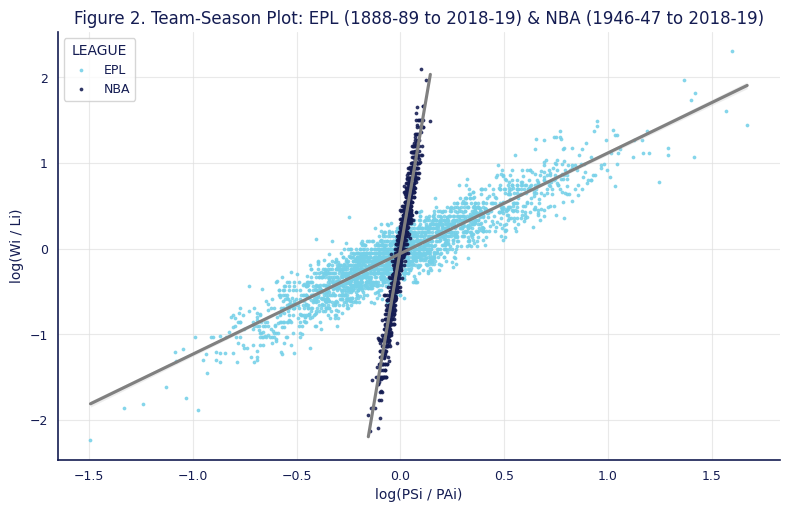

Exported: team_season_plot.html
Exported: team_season_plot.json


In [18]:
# prepare data for regression
df_reg = df_team.copy()
df_reg = df_reg.loc[(df_reg['PS']>0) & (df_reg['PA']>0) & (df_reg['wi']>0) & (df_reg['wi']<1)]
df_reg['lnwi']=np.log(df_reg['wi']/(1-df_reg['wi']))
df_reg['lnPSPA']=np.log(df_reg['PS']/df_reg['PA'])
df_reg = df_reg.reset_index()

# Create static seaborn plot
NBA_and_EPL = df_reg[df_reg['LEAGUE'].isin(['NBA', 'EPL'])]
grid = sns.lmplot(data=NBA_and_EPL,
           x='lnPSPA',
           y='lnwi',
           hue='LEAGUE',
           scatter_kws=dict(s=3),
           line_kws=dict(color="grey"),
           facet_kws=dict(legend_out=False),
           aspect=1.6)

# Apply custom styling
style_lmplot(grid, chart_colors)

plt.title('Figure 2. Team-Season Plot: EPL (1888-89 to 2018-19) & NBA (1946-47 to 2018-19)')
plt.xlabel('log(PSi / PAi)')
plt.ylabel('log(Wi / Li)')
plt.show()

# Create and display interactive Plotly version
fig = create_plotly_scatterplot(
    data=NBA_and_EPL,
    x_col='lnPSPA',
    y_col='lnwi', 
    hue_col='LEAGUE',
    title='Figure 2. Team-Season Plot: EPL (1888-89 to 2018-19) & NBA (1946-47 to 2018-19)',
    show_regression=True
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "team_season_plot", "Team-Season Analysis")

In [19]:
# Compute standard regression results by team-season for 2010-19 period
df_ols = df_reg.loc[(df_reg['YEAR_ID']>=st_year_) & (df_reg['YEAR_ID']<=end_year_)]
ols=df_ols.groupby(['LEAGUE']).apply(ols_coef,xcol=['lnPSPA'],ycol=['lnwi'])
ols = ols.droplevel(1).sort_values(['λ']).reset_index().round(2)
style_table(ols, hide_index=False)

/tmp/ipykernel_94255/1625533100.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,LEAGUE,adj.,adj. se,λ,λ se,nobs,adj. $R^2$
0,EPL,-0.150000,0.010000,1.240000,0.020000,200.000000,0.940000
1,MLB,-0.000000,0.010000,1.780000,0.040000,300.000000,0.890000
2,NHL,0.240000,0.010000,2.060000,0.040000,302.000000,0.910000
3,SUP,-0.030000,0.030000,2.600000,0.090000,154.000000,0.840000
4,NFL,0.020000,0.020000,2.840000,0.080000,319.000000,0.810000
5,LAX,-0.020000,0.010000,3.170000,0.050000,655.000000,0.840000
6,AFL,-0.020000,0.020000,3.570000,0.090000,177.000000,0.900000
7,IPL,-0.020000,0.040000,6.790000,0.650000,84.000000,0.570000
8,NBA,-0.000000,0.010000,14.320000,0.210000,300.000000,0.940000


### Save into ArcticDB

In [20]:
analysis.write('ols', ols);

### Figure 3a -- 2010 to 2019

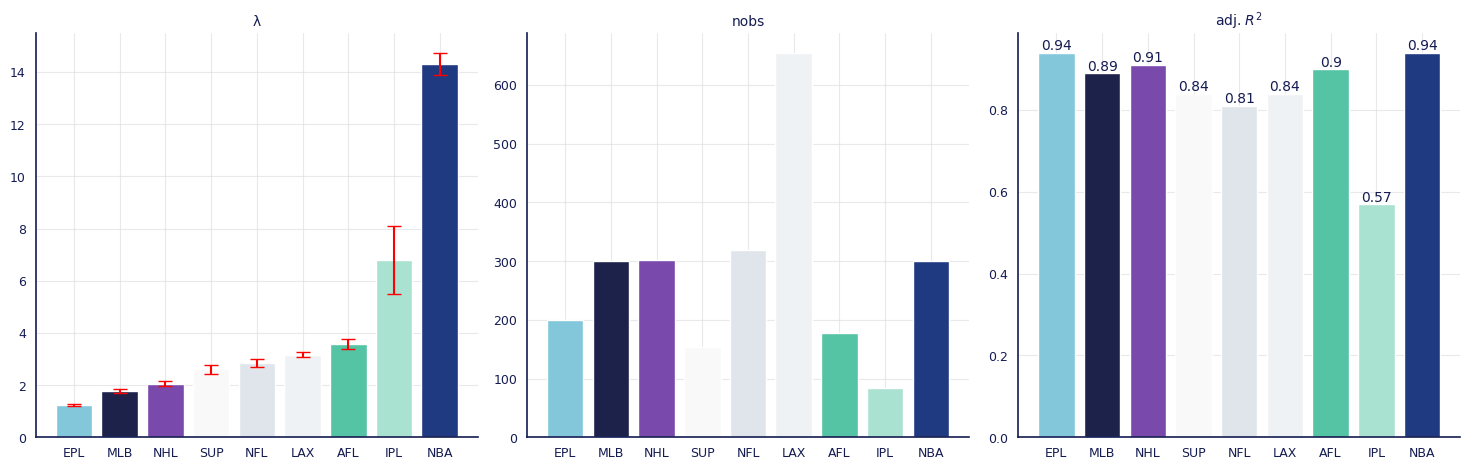

Exported: ols_results_catplot.html
Exported: ols_results_catplot.json


In [21]:
# Create static seaborn catplot
grid = sns.catplot(ols.melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_order=["λ", "nobs", "adj. $R^2$"],
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name}")

# Apply custom styling
style_catplot(grid, chart_colors)

# add error bars to λ
axis = grid.facet_axis(0, 0, True)
axis.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, fmt="none", capsize=5, color="r")
# add labels to R^2
axis = grid.facet_axis(0, 2, True)
[axis.bar_label(c, fontsize=10) for c in axis.containers]
plt.show()

# Prepare data for interactive Plotly version with error bars
ols_melted = ols.melt(['LEAGUE'])
# Add error column - only λ has error bars (2 * standard error)
ols_melted['error'] = ols_melted.apply(lambda row: 
    ols.loc[ols['LEAGUE'] == row['LEAGUE'], 'λ se'].iloc[0] * 2 
    if row['variable'] == 'λ' else None, axis=1)

# Create and display interactive Plotly version
fig = create_plotly_catplot(
    data=ols_melted,
    x_col="LEAGUE",
    y_col="value",
    hue_col="LEAGUE",
    col_col="variable",
    col_order=["λ", "nobs", "adj. $R^2$"],
    title="Figure 3a. OLS Results by League, 2010-2019 Seasons",
    sharey=False,
    error_col="error",
    add_value_labels=True  # Show values on R^2 bars like the seaborn version
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "ols_results_catplot", "OLS Results by League")

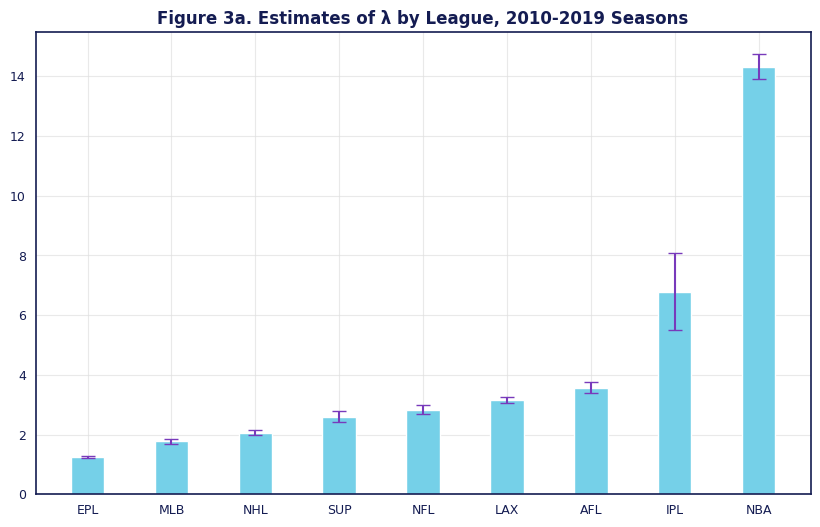

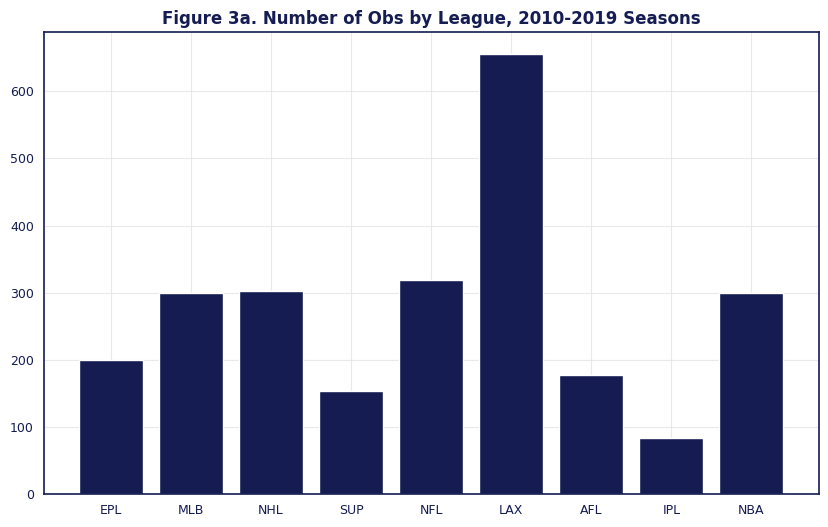

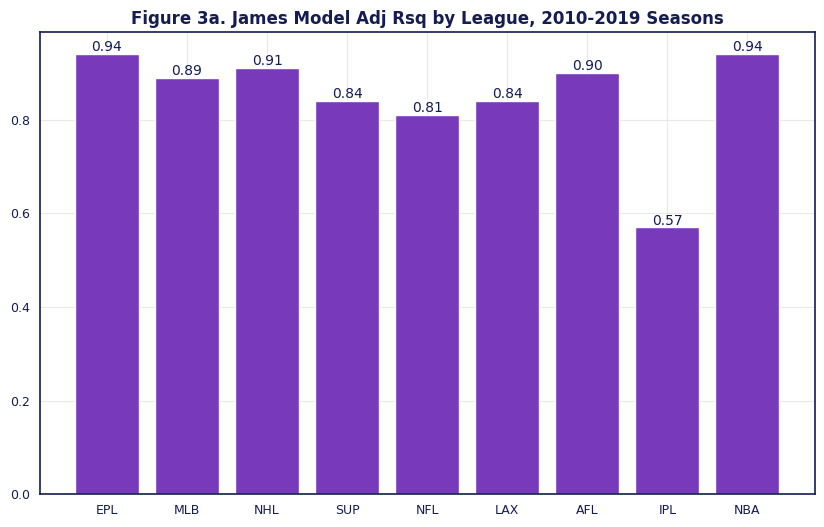

Exported: lambda_estimates.html
Exported: lambda_estimates.json


Exported: number_observations.html
Exported: number_observations.json


Exported: adjusted_rsquared.html
Exported: adjusted_rsquared.json


In [22]:
bar_width = 0.4
x = np.arange(len(ols['LEAGUE']))

# First chart - Lambda estimates
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['λ'], bar_width, 
              color=chart_colors['primary_color'], label='OLS')
ax.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, 
            fmt="none", capsize=5, color=chart_colors['accent_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. Estimates of λ by League, 2010-2019 Seasons')
plt.show()

# Second chart - Number of Observations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['nobs'], 
              color=chart_colors['secondary_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. Number of Obs by League, 2010-2019 Seasons')
plt.show()

# Third chart - Adjusted R-squared
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['adj. $R^2$'], 
              color=chart_colors['accent_color'])
ax.bar_label(bars, fmt='%.2f', color=chart_colors['text_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. James Model Adj Rsq by League, 2010-2019 Seasons')
plt.show()

# Create and display interactive Plotly versions

# 1. Lambda estimates with error bars
fig1 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='λ',
    title='Figure 3a. Estimates of λ by League, 2010-2019 Seasons',
    error_col='λ se',  # Error bars (will be multiplied by 2 in the function)
    add_value_labels=False
)
# Multiply error bars by 2 to match matplotlib version
fig1.data[0].error_y.array = fig1.data[0].error_y.array * 2
fig1.show()
export_plot(fig1, "lambda_estimates", "Lambda Estimates by League")

# 2. Number of observations
fig2 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='nobs',
    title='Figure 3a. Number of Obs by League, 2010-2019 Seasons',
    add_value_labels=False
)
# Use secondary color
fig2.data[0].marker.color = colors['secondary_color']
fig2.show()
export_plot(fig2, "number_observations", "Number of Observations by League")

# 3. Adjusted R-squared with value labels
fig3 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='adj. $R^2$',
    title='Figure 3a. James Model Adj Rsq by League, 2010-2019 Seasons',
    add_value_labels=True
)
# Use accent color
fig3.data[0].marker.color = colors['accent_color']
fig3.show()
export_plot(fig3, "adjusted_rsquared", "Adjusted R-squared by League")

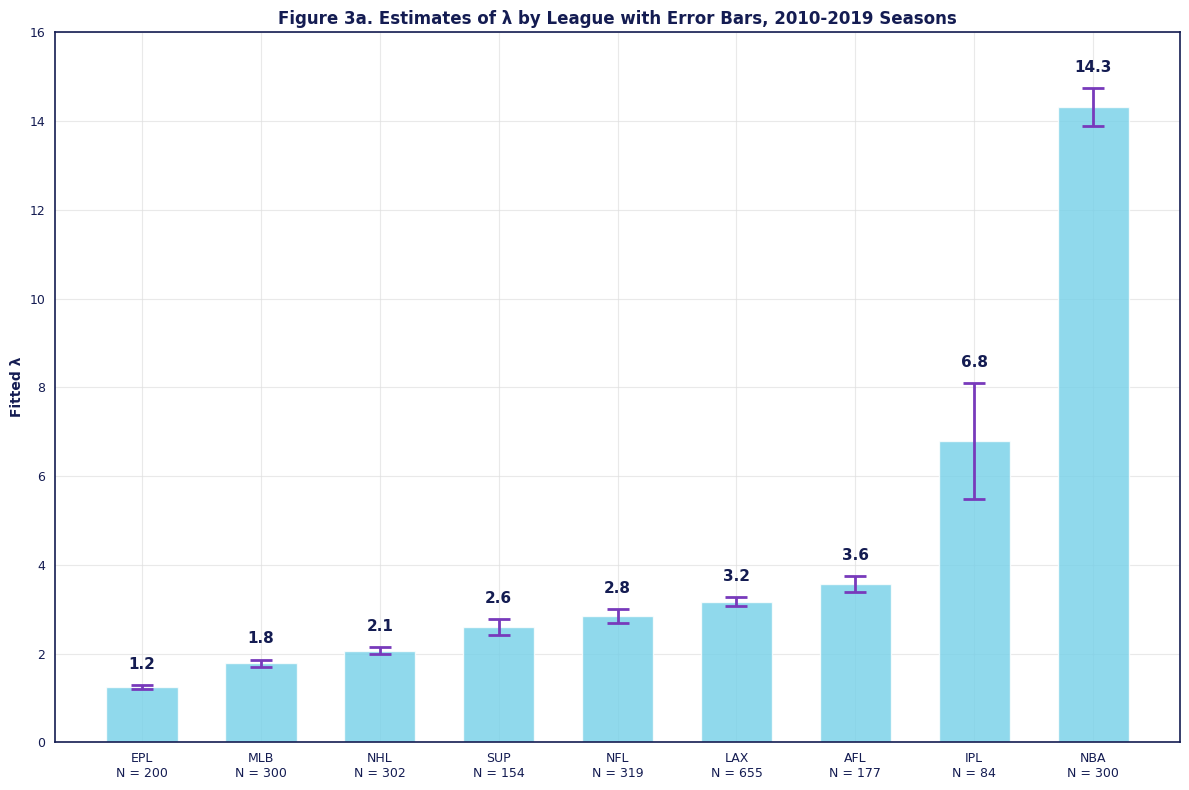

Exported: lambda_estimates_complete.html
Exported: lambda_estimates_complete.json


In [23]:
# Figure 3a - Single Lambda Plot with Error Bars and N Values
# Sort by lambda values (ascending order)
ols_sorted = ols.sort_values('λ').copy()

# Create the matplotlib version
fig, ax = plt.subplots(figsize=(12, 8))

# Create bar chart
bars = ax.bar(range(len(ols_sorted)), ols_sorted['λ'], 
              color=chart_colors['primary_color'], alpha=0.8, width=0.6)

# Add error bars (±2 standard errors)
ax.errorbar(range(len(ols_sorted)), ols_sorted['λ'], 
            yerr=ols_sorted['λ se'] * 2, 
            fmt="none", capsize=8, capthick=2, 
            color=chart_colors['accent_color'], linewidth=2)

# Add value labels on top of bars
for i, (idx, row) in enumerate(ols_sorted.iterrows()):
    ax.text(i, row['λ'] + row['λ se'] * 2 + 0.3, f'{row["λ"]:.1f}', 
            ha='center', va='bottom', fontweight='bold', 
            fontsize=11, color=chart_colors['text_color'])

# Set x-axis labels with N values
x_labels = [f"{row['LEAGUE']}\nN = {int(row['nobs'])}" for _, row in ols_sorted.iterrows()]
ax.set_xticks(range(len(ols_sorted)))
ax.set_xticklabels(x_labels, fontsize=11)

# Styling
ax.set_ylabel('Fitted λ', fontsize=14, fontweight='bold')
ax.set_ylim(0, 16)
ax.grid(True, axis='y', alpha=0.3, color=chart_colors['secondary_color'])
ax.set_axisbelow(True)

# Apply custom styling
style_matplotlib_chart(ax, chart_colors, 
                      'Figure 3a. Estimates of λ by League with Error Bars, 2010-2019 Seasons')

plt.tight_layout()
plt.show()

# Create interactive Plotly version
fig_plotly = create_plotly_bar_chart(
    data=ols_sorted,
    x_col='LEAGUE',
    y_col='λ',
    title='Figure 3a. Estimates of λ by League with Error Bars, 2010-2019 Seasons',
    error_col='λ se',
    add_value_labels=True
)

# Multiply error bars by 2 to show ±2 standard errors
fig_plotly.data[0].error_y.array = fig_plotly.data[0].error_y.array * 2

# Update x-axis labels to include N values
x_labels_plotly = [f"{row['LEAGUE']}<br>N = {int(row['nobs'])}" for _, row in ols_sorted.iterrows()]
fig_plotly.update_xaxes(
    tickmode='array',
    tickvals=list(range(len(ols_sorted))),
    ticktext=x_labels_plotly
)

# Update layout for better spacing
fig_plotly.update_layout(
    yaxis_title="Fitted λ",
    height=600,
    margin=dict(b=100)  # More bottom margin for N values
)

fig_plotly.show()

# Export the plot
export_plot(fig_plotly, "lambda_estimates_complete", "Lambda Estimates with Error Bars")

**Source:** Various (listed in Appendix) as at January 2025. 

**Key:** Australian Football League (AFL), English Premier League (EPL), Indian Premier League (IPL), NCAA Men's Division I Lacrosse (LAX), Major League Baseball (MLB), National Basketball Association (NBA), National Football League (NFL), National Hockey League (NHL), Super Rugby Pacific (SUP)

**Note:** Error bars represent ±2 standard errors around the coefficient estimate. N is the number of team-seasons used to estimate the model.

The λ estimates and errors are shown in Figure 3a. As we've noted, the EPL and NBA sit at the extremes. The model fits all sports well with statistically significant coefficients. The confidence bands around our estimate for the IPL is wider (also adjusted R² is 0.57 for the IPL compared to a range of 0.81 to 0.94 for the other leagues). For those that are interested, the poorer fit for the IPL we believe is due to the limited number of teams each season (8–10) and the truncated game effect in Twenty20 Cricket, discussed in Appendix A, which we can only partially adjust for.

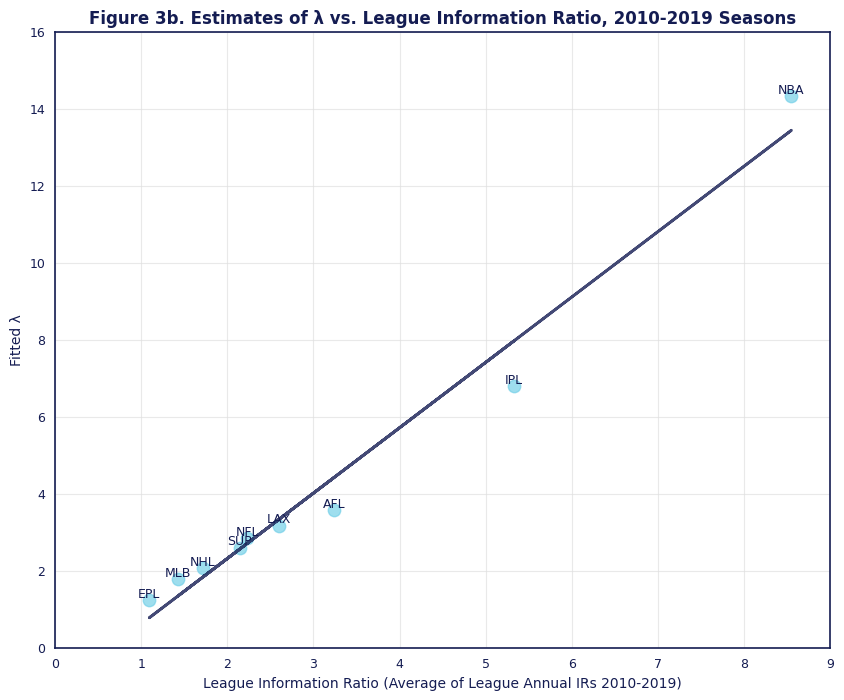

Exported: lambda_vs_information_ratio.html
Exported: lambda_vs_information_ratio.json


In [24]:
# calculate mean league IRs group by league-season
df_leagueM = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).mean()
df_leagueS = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).std()
df_leagueIR = df_leagueM['PS']/df_leagueS['PS']
df_leagueIR = df_leagueIR.reset_index().rename(columns={'PS': 'IR'})

# calc 10 year average for 2010-2019
df_leagueIR10 = df_leagueIR.loc[(df_leagueIR['YEAR_ID']>=st_year_) & (df_leagueIR['YEAR_ID']<=end_year_)]
df_leagueIR10 = df_leagueIR10[['LEAGUE','IR']].groupby(['LEAGUE']).mean()
df_leagueIR10 = df_leagueIR10.reset_index().rename(columns={'IR': 'IR10'})
df_leagueIR10 = df_leagueIR10.merge(ols, how='left', on=['LEAGUE'])

# Create static matplotlib scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=df_leagueIR10['IR10'], y=df_leagueIR10['λ'], 
          color=chart_colors['primary_color'], s=80, alpha=0.7)

# Fit a linear regression model
model=sm.OLS(df_leagueIR10['λ'],sm.add_constant(df_leagueIR10['IR10'])).fit()    

# Plot the regression line
ax.plot(df_leagueIR10['IR10'], model.predict(), 
        color=chart_colors['secondary_color'], linewidth=2, alpha=0.8)

# Add labels to the data points
for i in range(len(df_leagueIR10)):
    ax.text(df_leagueIR10['IR10'].iloc[i], df_leagueIR10['λ'].iloc[i], 
           f"{df_leagueIR10['LEAGUE'].iloc[i]}", 
           fontsize=9, ha='center', va='bottom',
           color=chart_colors['text_color'])
    
ax.set_xlabel('League Information Ratio (Average of League Annual IRs 2010-2019)') 
ax.set_ylabel('Fitted λ')
ax.set_xlim(0,9)
ax.set_ylim(0,16)

# Apply custom styling
style_matplotlib_chart(ax, chart_colors, 'Figure 3b. Estimates of λ vs. League Information Ratio, 2010-2019 Seasons')
plt.show()

# Create and display interactive Plotly version
fig = create_plotly_scatterplot(
    data=df_leagueIR10,
    x_col='IR10',
    y_col='λ',
    title='Figure 3b. Estimates of λ vs. League Information Ratio, 2010-2019 Seasons',
    show_regression=True,
    text_col='LEAGUE',  # Add league labels to data points
    xlim=(0, 9),        # Match matplotlib axis limits
    ylim=(0, 16)
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "lambda_vs_information_ratio", "Lambda vs Information Ratio")

In [25]:
# Rolling 10-Year Lambda Analysis
# First, let's check what columns are available in the league data
print("Checking available columns in league data...")
sample_league = league_data.read('MLB').data
print(f"Available columns: {list(sample_league.columns)}")
print(f"Sample data shape: {sample_league.shape}")
print("\nFirst few rows:")
print(sample_league.head())

def calculate_rolling_lambdas(league_name, window_years=10, min_observations=50):
    """
    Calculate rolling lambda estimates for a specific league.
    
    Args:
        league_name: Name of the league
        window_years: Size of rolling window in years
        min_observations: Minimum observations required for regression
    
    Returns:
        DataFrame with year, lambda, std_error, adj_r2, nobs
    """
    # Get league data from ArcticDB
    league_df = league_data.read(league_name).data
    
    # Check if the columns exist, if not use the renamed columns from processed data
    if 'FREQ_RUNS_S' in league_df.columns:
        ps_col = 'FREQ_RUNS_S'
        pa_col = 'FREQ_RUNS_A'
    else:
        ps_col = 'PS'
        pa_col = 'PA'
    
    # Filter for team-season data (same processing as before)
    team_season = league_df.groupby(['YEAR_ID','TEAM_ID']).agg(
        PS=(ps_col, 'mean'),
        PA=(pa_col, 'mean'),
        wi=('wi', 'mean'),
        nobs=('wi', 'count')
    ).reset_index()
    
    # Filter valid observations
    team_season = team_season.loc[
        (team_season['PS'] > 0) & 
        (team_season['PA'] > 0) & 
        (team_season['wi'] > 0) & 
        (team_season['wi'] < 1)
    ]
    
    # Create log variables
    team_season['lnwi'] = np.log(team_season['wi'] / (1 - team_season['wi']))
    team_season['lnPSPA'] = np.log(team_season['PS'] / team_season['PA'])
    
    # Get year range
    years = sorted(team_season['YEAR_ID'].unique())
    start_year = min(years) + window_years - 1  # First complete window
    end_year = max(years)
    
    results = []
    
    for year in range(start_year, end_year + 1):
        # Define window
        window_start = year - window_years + 1
        window_data = team_season[
            (team_season['YEAR_ID'] >= window_start) & 
            (team_season['YEAR_ID'] <= year)
        ]
        
        if len(window_data) >= min_observations:
            try:
                # Run OLS regression
                model = sm.OLS(window_data['lnwi'], 
                              sm.add_constant(window_data['lnPSPA'])).fit()
                
                results.append({
                    'year': year,
                    'lambda': model.params.iloc[1],
                    'lambda_se': model.bse.iloc[1],
                    'adj_r2': model.rsquared_adj,
                    'nobs': len(window_data)
                })
            except:
                # Skip if regression fails
                continue
    
    return pd.DataFrame(results)

# Calculate rolling lambdas for leagues shown in the reference chart
target_leagues = ['AFL', 'EPL', 'MLB', 'NBA', 'NFL', 'NHL']  # Matching the 2x3 layout
rolling_results = {}

print("\nCalculating rolling 10-year lambda estimates...")
for league in target_leagues:
    print(f"Processing {league}...")
    rolling_results[league] = calculate_rolling_lambdas(league)
    print(f"  {league}: {len(rolling_results[league])} data points")

print("Rolling lambda calculations complete!")

Checking available columns in league data...
Available columns: ['YEAR_ID', 'TEAM_ID', 'OPP_TEAM_ID', 'PS', 'PA', 'date', 'home', 'wi', 'LEAGUE']
Sample data shape: (436786, 9)

First few rows:
        YEAR_ID TEAM_ID OPP_TEAM_ID  PS  PA        date  home   wi LEAGUE
138750     1871     ATL         WS3  20  18  1871-05-05     0  1.0    MLB
138751     1871     ATL         TRO   9   5  1871-05-09     0  1.0    MLB
138752     1871     ATL         TRO  14  29  1871-05-16     1  0.0    MLB
138753     1871     ATL         PH1  11   8  1871-05-20     1  1.0    MLB
138754     1871     ATL         WS3   4   4  1871-05-24     1  0.5    MLB

Calculating rolling 10-year lambda estimates...
Processing AFL...
  AFL: 114 data points
Processing EPL...
  EPL: 122 data points
Processing MLB...
  MLB: 140 data points
Processing NBA...
  NBA: 64 data points
Processing NFL...
  NFL: 89 data points
Processing NHL...
  NHL: 93 data points
Rolling lambda calculations complete!


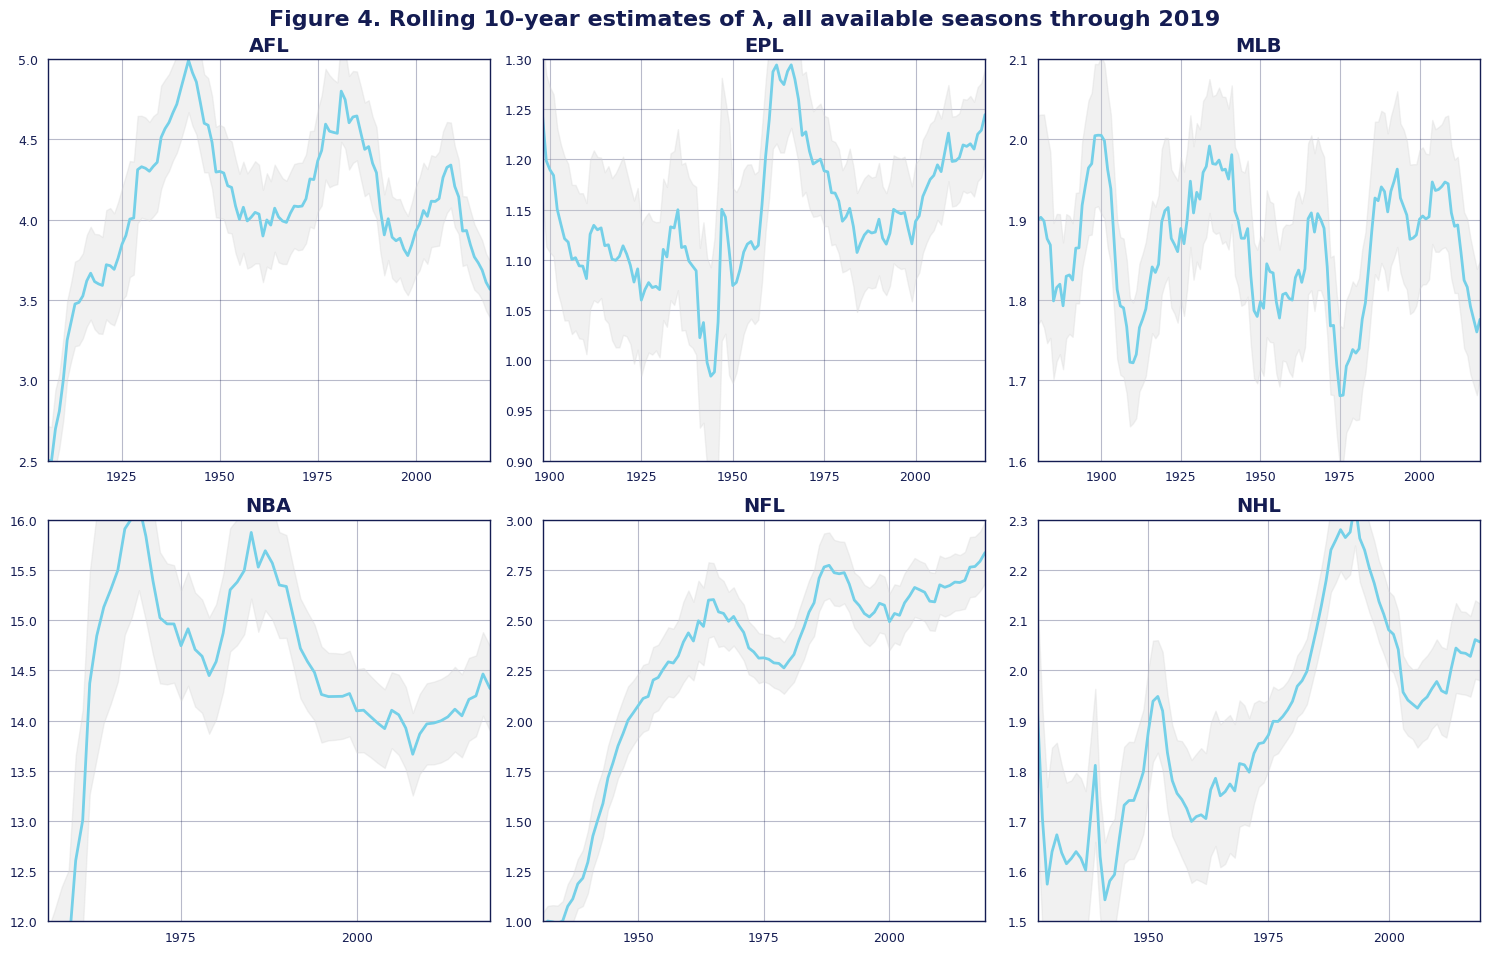

Exported: rolling_lambda_time_series.html
Exported: rolling_lambda_time_series.json


In [26]:
# Create Rolling 10-Year Lambda Time Series Plot (2x3 layout)
import matplotlib.patches as patches

# Set up 2x3 subplot layout matching the reference chart
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Define the order to match the reference chart layout
league_layout = ['AFL', 'EPL', 'MLB', 'NBA', 'NFL', 'NHL']

for i, league in enumerate(league_layout):
    ax = axes[i]
    
    if league in rolling_results and len(rolling_results[league]) > 0:
        data = rolling_results[league]
        
        # Create confidence band (±2 standard errors)
        upper_bound = data['lambda'] + 2 * data['lambda_se']
        lower_bound = data['lambda'] - 2 * data['lambda_se']
        
        # Plot confidence band
        ax.fill_between(data['year'], lower_bound, upper_bound, 
                       alpha=0.3, color='lightgray', label='±2 SE')
        
        # Plot lambda line
        ax.plot(data['year'], data['lambda'], 
               color=chart_colors['primary_color'], linewidth=2, 
               label='λ estimate')
        
        # Set individual y-axis ranges to match reference chart
        if league == 'AFL':
            ax.set_ylim(2.5, 5.0)
        elif league == 'EPL':
            ax.set_ylim(0.9, 1.3)
        elif league == 'MLB':
            ax.set_ylim(1.6, 2.1)
        elif league == 'NBA':
            ax.set_ylim(12, 16)
        elif league == 'NFL':
            ax.set_ylim(1.0, 3.0)
        elif league == 'NHL':
            ax.set_ylim(1.5, 2.3)
        
        # Format x-axis to show reasonable year ranges
        year_min, year_max = data['year'].min(), data['year'].max()
        if year_max - year_min > 50:
            # For long series, show every 25 years
            tick_years = range(int(year_min + 25 - year_min % 25), int(year_max + 1), 25)
        elif year_max - year_min > 20:
            # For medium series, show every 20 years
            tick_years = range(int(year_min + 20 - year_min % 20), int(year_max + 1), 20)
        else:
            # For short series, show every 10 years
            tick_years = range(int(year_min + 10 - year_min % 10), int(year_max + 1), 10)
        
        ax.set_xticks(tick_years)
        ax.set_xlim(year_min, year_max)
        
    else:
        # If no data, show empty plot
        ax.text(0.5, 0.5, f'No data\navailable\nfor {league}', 
               ha='center', va='center', transform=ax.transAxes,
               fontsize=12, color='gray')
    
    # Styling
    ax.set_title(league, fontsize=14, fontweight='bold', 
                color=chart_colors['text_color'])
    ax.grid(True, alpha=0.3, color=chart_colors['secondary_color'])
    ax.set_axisbelow(True)
    
    # Style spines and ticks
    for spine in ax.spines.values():
        spine.set_color(chart_colors['secondary_color'])
        spine.set_linewidth(1)
    ax.tick_params(colors=chart_colors['text_color'], labelsize=9)

# Set overall title
fig.suptitle('Figure 4. Rolling 10-year estimates of λ, all available seasons through 2019', 
            fontsize=16, fontweight='bold', color=chart_colors['text_color'], y=0.95)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# Create interactive Plotly version
from plotly.subplots import make_subplots

# Set up Plotly subplot structure
fig_plotly = make_subplots(
    rows=2, cols=3,
    subplot_titles=league_layout,
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

for i, league in enumerate(league_layout):
    row = (i // 3) + 1
    col = (i % 3) + 1
    
    if league in rolling_results and len(rolling_results[league]) > 0:
        data = rolling_results[league]
        
        # Add confidence band
        upper_bound = data['lambda'] + 2 * data['lambda_se']
        lower_bound = data['lambda'] - 2 * data['lambda_se']
        
        # Create filled area for confidence band
        years_extended = list(data['year']) + list(data['year'][::-1])
        bounds_extended = list(upper_bound) + list(lower_bound[::-1])
        
        fig_plotly.add_trace(
            dict(
                type='scatter',
                x=years_extended,
                y=bounds_extended,
                fill='toself',
                fillcolor='rgba(128,128,128,0.3)',
                line=dict(color='rgba(255,255,255,0)'),
                name='±2 SE',
                showlegend=(i == 0),
                hoverinfo='skip'
            ),
            row=row, col=col
        )
        
        # Add lambda line
        fig_plotly.add_trace(
            dict(
                type='scatter',
                x=data['year'],
                y=data['lambda'],
                mode='lines',
                line=dict(color=colors['primary_color'], width=2),
                name='λ estimate',
                showlegend=(i == 0),
                hovertemplate=f'{league}<br>Year: %{{x}}<br>λ: %{{y:.2f}}<extra></extra>'
            ),
            row=row, col=col
        )

# Update layout
fig_plotly.update_layout(
    title='Figure 4. Rolling 10-year estimates of λ, all available seasons through 2019',
    height=700,
    template='custom_theme',
    showlegend=True,
    margin=dict(t=100, b=50)
)

# Update individual subplot y-axes to match reference chart ranges
y_ranges = {
    'AFL': [2.5, 5.0],
    'EPL': [0.9, 1.3], 
    'MLB': [1.6, 2.1],
    'NBA': [12, 16],
    'NFL': [1.0, 3.0],
    'NHL': [1.5, 2.3]
}

for i, league in enumerate(league_layout):
    row = (i // 3) + 1
    col = (i % 3) + 1
    if league in y_ranges:
        fig_plotly.update_yaxes(range=y_ranges[league], row=row, col=col)

fig_plotly.show()

# Export the plot
export_plot(fig_plotly, "rolling_lambda_time_series", "Rolling 10-Year Lambda Estimates")

**Source:** Various (listed in Appendix) as at January 2025. 

**Key:** Australian Football League (AFL), English Premier League (EPL), Major League Baseball (MLB), National Basketball Association (NBA), National Football League (NFL), National Hockey League (NHL)

**Note:** Shaded regions represent ±2 standard errors around the coefficient estimate.

The rolling 10-year lambda estimates shown in Figure 4 reveal the temporal evolution of the Pythagorean exponent across different sports leagues. Each panel shows how λ has changed over time, providing insights into the historical development of competitive balance and scoring dynamics within each league. The confidence bands help assess the statistical precision of these estimates over different time periods.